# Prueba de sensores

En este notebook se dispondran los scripts para la prueba de los sensores instalados en la tarjeta SmartBedding-RPi

### Prueba de acelerometro

Aqui se tiene un ejemplo de la lectura del acelerometro

### Librerias

In [1]:
import spidev   # libreria para comunicacion SPI
import time
import struct
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Creacion de objeto spi para comunicacion con sensor IMU

In [2]:
spi = spidev.SpiDev()
spi.open(0, 0)  # bus 0, CE0
spi.max_speed_hz = 4000000
spi.mode = 0b11  # ICM requiere SPI mode 3


def write_register(spi, reg_addr, data):
    """
    Escribe un solo byte 'data' en el registro 'reg_addr' del ICM42605.
    """
    reg_addr_r = reg_addr & 0x7F  # Asegura que el bit 7 esté en 0 para escritura
    spi.xfer2([reg_addr_r, data])
    # Read back the register
    resp = read_registers(spi, reg_addr)
    if resp[0] == data:
        return resp, 1
    else:
        return resp, -1 
    

def read_registers(spi, reg_addr, length=1):
    """
    Lee 'length' bytes desde el registro 'reg_addr' del ICM42605.
    Retorna una lista con los bytes leídos.
    """
    reg_addr = reg_addr | 0x80  # Activa el bit 7 para indicar lectura
    response = spi.xfer2([reg_addr] + [0x00] * length)
    return response[1:]  # omitir el primer byte (eco del reg_addr)

Funciones para control de IMU

### Identificacion del dispositivo

In [3]:
# Dirección del registro WHO_AM_I del ICM42605
REG_WHO_AM_I = 0x75

# data = read_registers(spi, 0x75)
# print(data)

# Leer WHO_AM_I
whoami = read_registers(spi, REG_WHO_AM_I)[0]
print(f"WHO_AM_I: 0x{whoami:02X}") # Se espera 0x42

WHO_AM_I: 0x42


# Inicializacion de dispositivo

Escritura de registros de inicializacion

### Software Reset

In [4]:
# Reset
ICM42605_DEVICE_CONFIG = 0x11

resp = write_register(spi, ICM42605_DEVICE_CONFIG, 0x01)
print(f"Dato: 0x{resp[0][0]:02X}")
print(f"Acept: {resp[1]}")


Dato: 0x00
Acept: -1


### Activacion de la IMU

In [5]:
# Activacion del sensor IMU

ICM42605_PWR_MGMT0 = 0x4E

resp = read_registers(spi, ICM42605_PWR_MGMT0)
print(f"Dato: 0x{resp[0]:02X}")

resp = write_register(spi, ICM42605_PWR_MGMT0, 0x0F)
print(f"Dato: 0x{resp[0][0]:02X}")
print(f"Acept: {resp[1]}")

Dato: 0x00
Dato: 0x0F
Acept: 1


### Configuracion de escala de Giroscopio y Aceletrometro

Aqui se configura la escala del Giroscopio

In [6]:
# Configuracion del Giroscopio
ICM42605_GYRO_CONFIG0 = 0x4F

GFS_2000DPS   = 0x00   # default
GFS_1000DPS   = 0x01
GFS_500DPS    = 0x02
GFS_250DPS    = 0x03
GFS_125DPS    = 0x04
GFS_62_5DPS   = 0x05
GFS_31_25DPS  = 0x06
GFS_15_125DPS = 0x07

GODR_8000Hz   = 0x03
GODR_4000Hz   = 0x04
GODR_2000Hz   = 0x05
GODR_1000Hz   = 0x06   # default
GODR_200Hz    = 0x07
GODR_100Hz    = 0x08
GODR_50Hz     = 0x09
GODR_25Hz     = 0x0A
GODR_12_5Hz   = 0x0B
GODR_500Hz    = 0x0F

GODR = GODR_1000Hz
Gscale = GFS_250DPS

resp = read_registers(spi, ICM42605_GYRO_CONFIG0)
print(f"Dato: 0x{resp[0]:02X}")

resp = write_register(spi, ICM42605_GYRO_CONFIG0, GODR | Gscale << 5)
print(f"Dato: 0x{resp[0][0]:02X}")
print(f"Acept: {resp[1]}")

Dato: 0x06
Dato: 0x66
Acept: 1


Aqui se configura la escala del Acelerometro

In [7]:
# Configuracion del Giroscopio
ICM42605_ACCEL_CONFIG0 = 0x50

AFS_2G        = 0x03
AFS_4G        = 0x02
AFS_8G        = 0x01
AFS_16G       = 0x00  # default

AODR_8000Hz   = 0x03
AODR_4000Hz   = 0x04
AODR_2000Hz   = 0x05
AODR_1000Hz   = 0x06  # default
AODR_200Hz    = 0x07
AODR_100Hz    = 0x08
AODR_50Hz     = 0x09
AODR_25Hz     = 0x0A
AODR_12_5Hz   = 0x0B
AODR_6_25Hz   = 0x0C
AODR_3_125Hz  = 0x0D
AODR_1_5625Hz = 0x0E
AODR_500Hz    = 0x0F

AODR = AODR_1000Hz
Ascale = AFS_2G

resp = read_registers(spi, ICM42605_ACCEL_CONFIG0)
print(f"Dato: 0x{resp[0]:02X}")

resp = write_register(spi, ICM42605_ACCEL_CONFIG0, AODR | Ascale << 5)
print(f"Dato: 0x{resp[0][0]:02X}")
print(f"Acept: {resp[1]}")

Dato: 0x06
Dato: 0x66
Acept: 1


### Configuracion de filtro para Gyro

In [8]:
# Configuracion del Giroscopio
ICM42605_GYRO_CONFIG1 = 0x51

resp = read_registers(spi, ICM42605_GYRO_CONFIG1)
print(f"Dato: 0x{resp[0]:02X}")

resp = write_register(spi, ICM42605_GYRO_CONFIG1, 0xD0) # set temperature sensor low pass filter to 5Hz, use first order gyro filter
print(f"Dato: 0x{resp[0][0]:02X}")
print(f"Acept: {resp[1]}")

Dato: 0x16
Dato: 0xD0
Acept: 1


### Lectura Inicial del sensor

In [9]:
# Dirección del registro WHO_AM_I del ICM42605
aRes = 1
gRes = 1

abias = np.zeros(3)
gbias = np.zeros(3)

def to_signed_16bit(val):
    # Convierte un entero de 16 bits sin signo a con signo (complemento a 2)
    return val - 0x10000 if val & 0x8000 else val

def readSensor(spi):
    TEMP_REG = 0x1D
    DATA_REG = 0x1F

    dest = np.zeros(6, dtype=int)
    acc  = np.zeros(3)
    gyr  = np.zeros(3)
    
    temp = read_registers(spi, TEMP_REG, length=14)  # Lee 14 bytes consecutivos
    
    # Temperatura
    raw_temp = (temp[0] << 8) | temp[1]
    raw_temp = to_signed_16bit(raw_temp)
    _t = raw_temp / 132.48 + 25
    
    # Datos acelerómetro y giroscopio
    for i in range(6):
        raw = (temp[2*i + 2] << 8) | temp[2*i + 3]
        dest[i] = to_signed_16bit(raw)
    
    acc[0] = dest[0] * aRes + abias[0]
    acc[1] = dest[1] * aRes + abias[1]
    acc[2] = dest[2] * aRes + abias[2]

    gyr[0] = dest[3] * gRes + gbias[0]
    gyr[1] = dest[4] * gRes + gbias[1]
    gyr[2] = dest[5] * gRes + gbias[2]

    return _t, acc, gyr

In [10]:
_t, acc, gyr = readSensor(spi)

print(_t)
print(acc)
print(gyr)


22.358091787439612
[  1016.  10064. -12666.]
[-195.  -17.  195.]


## Determinacion de Offset y Bias

In [11]:
# Calibracion de los sensores
aRes = (2**(AFS_2G+1)) / 32768
gRes = (2000/(2**(Gscale))) / 32768

suma   = np.zeros(6)

for i in range(0, 128):
    _t, acc, gyr = readSensor(spi)
    # suma[0] += _t
    suma[0] += acc[0]
    suma[1] += acc[1]
    suma[2] += acc[2]
    suma[3] += gyr[0]
    suma[4] += gyr[1]
    suma[5] += gyr[2]
    time.sleep(0.005)

abias = suma[0:3] * aRes / 128
gbias = suma[3:6] * gRes / 128

print(abias)
print(gbias)


[ 0.00024209  0.00240256 -0.00302127]
[-0.01313629 -0.00087266  0.01221406]


# Mediciones con el acelerometro

In [12]:
sample_rate = 20  # Hz
duration = 20     # segundos
num_samples = sample_rate * duration

acc_data = np.zeros((num_samples, 3))
gyr_data = np.zeros((num_samples, 3))
temp_data = np.zeros(num_samples)
timestamps = np.zeros(num_samples)

In [13]:
start_time = time.time()

for i in range(num_samples):
    now = time.time()
    t, acc, gyr = readSensor(spi)

    temp_data[i] = t
    acc_data[i] = acc
    gyr_data[i] = gyr
    timestamps[i] = now - start_time

    # Esperar el tiempo restante para cumplir los 20 Hz
    time.sleep(max(0, 1.0 / sample_rate - (time.time() - now)))

print("Finalizacion de muestreo")

Finalizacion de muestreo


### Grafica de movimiento

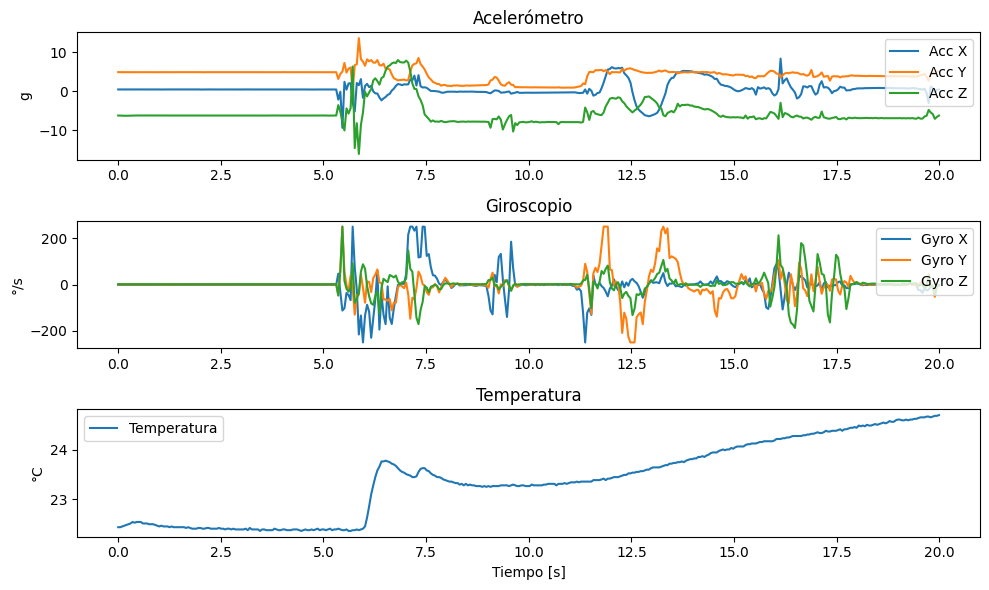

In [14]:
# Graficar acelerómetro
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(timestamps, acc_data[:, 0], label='Acc X')
plt.plot(timestamps, acc_data[:, 1], label='Acc Y')
plt.plot(timestamps, acc_data[:, 2], label='Acc Z')
plt.title('Acelerómetro')
plt.ylabel('g')
plt.legend()

# Graficar giroscopio
plt.subplot(3, 1, 2)
plt.plot(timestamps, gyr_data[:, 0], label='Gyro X')
plt.plot(timestamps, gyr_data[:, 1], label='Gyro Y')
plt.plot(timestamps, gyr_data[:, 2], label='Gyro Z')
plt.title('Giroscopio')
plt.ylabel('°/s')
plt.legend()

# Graficar temperatura
plt.subplot(3, 1, 3)
plt.plot(timestamps, temp_data, label='Temperatura')
plt.title('Temperatura')
plt.ylabel('°C')
plt.xlabel('Tiempo [s]')
plt.legend()

plt.tight_layout()
plt.show()

# Calculo de Cuaterniones

In [15]:
from ahrs.filters import Madgwick

def quat_to_euler(q):
    """
    Convierte un quaternion [w, x, y, z] a ángulos Euler (yaw, pitch, roll)
    en radianes.
    """
    w, x, y, z = q

    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if abs(sinp) >= 1:
        pitch = np.sign(sinp) * np.pi / 2  # usar 90 grados si está fuera del rango
    else:
        pitch = np.arcsin(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return np.array([yaw, pitch, roll])


In [16]:
# --- Aquí comienza tu código corregido ---

fs = 20  # frecuencia de muestreo en Hz
dt = 1/fs
t = timestamps

# Giroscopio: rotación alrededor de eje z, 90°/s constante
gyro = gyr_data

# Convertir giroscopio a rad/s para el filtro
gyro = np.deg2rad(gyro)

# Acelerómetro simulado: sin movimiento, solo gravedad en eje z
acc = acc_data

# Crear el filtro Madgwick
madgwick = Madgwick(frequency=fs)

# Array para guardar quaterniones estimados
quaternions = np.zeros((len(t), 4))

# Estado inicial (quaternion identidad)
q = np.array([1.0, 0.0, 0.0, 0.0])

# Loop para calcular orientación
for i in range(len(t)):
    q = madgwick.updateIMU(q, gyr=gyro[i], acc=acc[i])
    quaternions[i] = q

# Convertir quaterniones a ángulos Euler para visualizar (yaw, pitch, roll)
eulers = np.array([quat_to_euler(q) for q in quaternions])
eulers_deg = np.rad2deg(eulers)  # pasar a grados

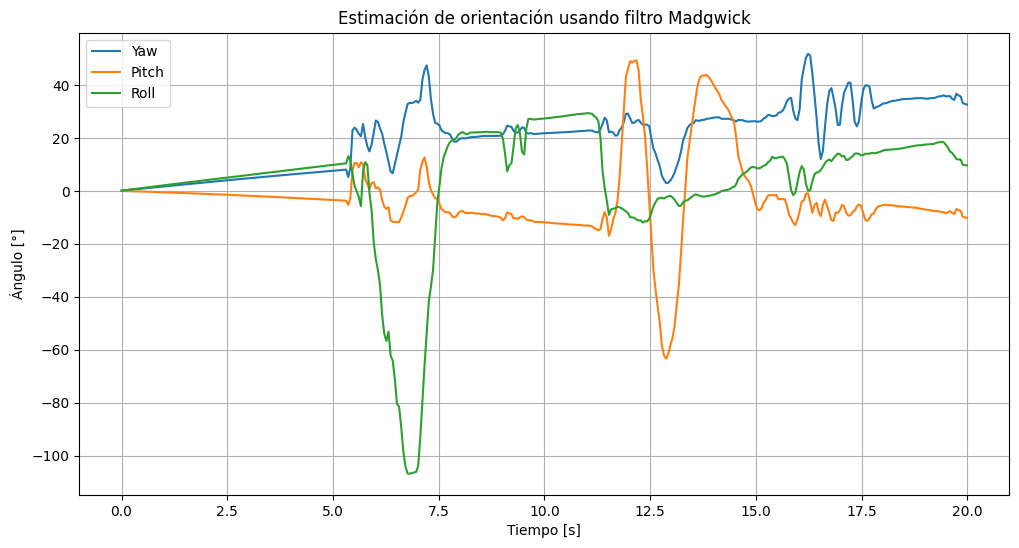

In [17]:
# Graficar
plt.figure(figsize=(12,6))
plt.plot(t, eulers_deg[:, 0], label='Yaw')
plt.plot(t, eulers_deg[:, 1], label='Pitch')
plt.plot(t, eulers_deg[:, 2], label='Roll')
plt.title('Estimación de orientación usando filtro Madgwick')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [°]')
plt.legend()
plt.grid()
plt.show()

In [18]:
# Crear DataFrame con todas las columnas
data = pd.DataFrame({
    'time': t,
    'acc_x': acc[:, 0],
    'acc_y': acc[:, 1],
    'acc_z': acc[:, 2],
    'gyro_x': gyro[:, 0],
    'gyro_y': gyro[:, 1],
    'gyro_z': gyro[:, 2],
    'quat_w': quaternions[:, 0],
    'quat_x': quaternions[:, 1],
    'quat_y': quaternions[:, 2],
    'quat_z': quaternions[:, 3],
})

# Guardar como archivo CSV
data.to_csv('imu_data.csv', index=False)

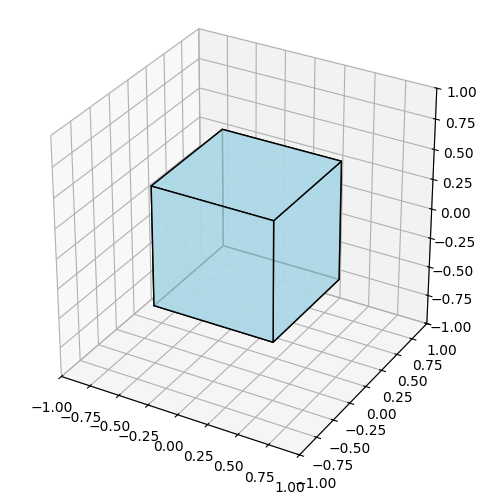

In [20]:
#### from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as R

def get_cube():
    r = [-0.5, 0.5]
    vertices = np.array([[x, y, z] for x in r for y in r for z in r])
    faces = [[vertices[j] for j in [0,1,3,2]],
             [vertices[j] for j in [4,5,7,6]],
             [vertices[j] for j in [0,1,5,4]],
             [vertices[j] for j in [2,3,7,6]],
             [vertices[j] for j in [1,3,7,5]],
             [vertices[j] for j in [0,2,6,4]]]
    return vertices, faces

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_box_aspect([1,1,1])

vertices, faces = get_cube()
cube = Poly3DCollection(faces, facecolors='lightblue', edgecolors='k', linewidths=1, alpha=0.8)
ax.add_collection3d(cube)

def update(frame):
    q = quaternions[frame]
    rot = R.from_quat([q[1], q[2], q[3], q[0]])  # [x,y,z,w]
    rotated = rot.apply(vertices)
    new_faces = [[rotated[j] for j in [0,1,3,2]],
                 [rotated[j] for j in [4,5,7,6]],
                 [rotated[j] for j in [0,1,5,4]],
                 [rotated[j] for j in [2,3,7,6]],
                 [rotated[j] for j in [1,3,7,5]],
                 [rotated[j] for j in [0,2,6,4]]]
    cube.set_verts(new_faces)
    return cube,

ani = FuncAnimation(fig, update, frames=400, interval=50)

# Guardar como .mp4
writer = FFMpegWriter(fps=20)
ani.save("cubo.mp4", writer=writer)

**Author**: Fabian Castaño